In [71]:
import torch

### Load Analyzed Games

In [102]:
# dataset = torch.load("datasets/dataset_all_games.pt")
dataset = torch.load("datasets/dataset_all_games_01.pt")

In [103]:
# dataset = [(white_analysis, black_analysis), (white_elo, black_elo)]
print(len(dataset)) # num of games
print(len(dataset[0][0][0])) # moves of first game (for white)
print(len(dataset[0][0][0][0])) # input size of the model

2000
14
771


### Modify the dataset for training

In [255]:
import random

total_games = len(dataset)
max_elo = max([max(game[1]) for game in dataset])

test_games = int(total_games * 0.15)

random.shuffle(dataset)
# print(torch.stack(dataset[0][0]))

# (2000, 2, nof_moves, input_size)
x_train = [torch.stack(game[0]) for game in dataset[:-test_games]]
y_train = [torch.tensor(game[1]).float().reshape((2, 1))/max_elo for game in dataset[:-test_games]]

x_test =  [torch.stack(game[0]) for game in dataset[-test_games:]]
y_test =  [torch.tensor(game[1]).float().reshape((2, 1))/max_elo for game in dataset[-test_games:]]

input_size = x_train[0].shape[2]

### Define the Model

In [256]:
import torch
from torch import nn, optim

In [235]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, X, h0=None, c0=None, train=True):
        # If X is a single sample, add a batch dimension
        if X.dim() == 2:
            X = X.unsqueeze(0)
            
        if c0 is None:
            c0 = torch.zeros(self.num_layers, X.size(0), self.hidden_size)
        if h0 is None:
            h0 = torch.zeros(self.num_layers, X.size(0), self.hidden_size)

        out, (hn, cn) = self.lstm(X, (h0, c0))
        
        out = self.fc(out[:, -1, :])

        return out, (hn, cn)

In [257]:
def initialize_model(input_size, hidden_size, num_layers):
    lstm_model = LSTM(input_size, hidden_size, num_layers)

    learning_rate = 0.01
    optimizer = optim.Adam(lstm_model.parameters(), lr=learning_rate)

    loss_func = nn.functional.mse_loss

    return lstm_model, optimizer, loss_func

lstm_model, optimizer, loss_func = initialize_model(input_size, 128, 2)

### Train the model

In [258]:
def train_model(model, optimizer, loss_func, train_data, num_epochs):

    # train_data = [X_train, y_train]
    x_train, y_train = train_data
    # x_train.shape = (batch_size, num_moves, input_size)
    # y_train.shape = (batch_size, 1)

    total_games = len(x_train)
    validation_games = int(total_games * 0.15)

    x_val = x_train[-validation_games:]
    y_val = y_train[-validation_games:]

    x_train = x_train[:-validation_games]
    y_train = y_train[:-validation_games]

    batch_size = len(x_train[0])

    loss_per_epoch = []
    
    

    for epoch in range(num_epochs):
        for batch, (x_game, y_game) in enumerate(zip(x_train, y_train)):

            cell_states = torch.zeros(model.num_layers, batch_size, model.hidden_size)
            hidden_states = torch.zeros(model.num_layers, batch_size, model.hidden_size)

            # BATCH GAMES TOGETHER BASED ON NUMBER OF MOVES
            # Will maybe change to transformers later

            elo_guess, (_hidden_states, _cell_states) = model(
                x_game, hidden_states, cell_states
            )

            loss = loss_func(elo_guess, y_game)

            optimizer.zero_grad()
            loss.backward()

            optimizer.step()

        cell_states = torch.zeros(model.num_layers, batch_size, model.hidden_size)
        hidden_states = torch.zeros(model.num_layers, batch_size, model.hidden_size)
        loss_sum = sum(
            loss_func(model(x_val[i], cell_states, hidden_states)[0], y_val[i]).item()
            for i in range(validation_games)
        )

        print(f"Epoch: {epoch + 1}, Validation Loss: {loss_sum/validation_games}")

        loss_per_epoch.append(loss_sum / (validation_games + 1))

    return loss_per_epoch


In [259]:
loss_graph = train_model(lstm_model, optimizer, loss_func, (x_train, y_train), num_epochs=5)

Epoch: 1, Validation Loss: 0.04413548411936134
Epoch: 2, Validation Loss: 0.029421987739367658
Epoch: 3, Validation Loss: 0.03307730721658028
Epoch: 4, Validation Loss: 0.026332656099482703
Epoch: 5, Validation Loss: 0.023361305817252286


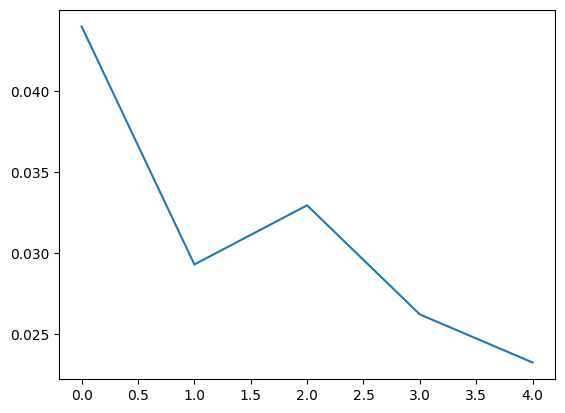

In [260]:
import matplotlib.pyplot as plt
plt.plot(loss_graph)

In [272]:
predictions = []
real_values = []

for x, y in zip(x_test, y_test):
    out = lstm_model.forward(x[0], train=False)[0] 
    # print(f"White Prediction: {int(out[0].item() * max_elo)} vs White Real Elo: {int(y[0].item() * max_elo)}")
    predictions.append(out[0].item() * max_elo)
    real_values.append(y[0].item() * max_elo)

    out = lstm_model.forward(x[1], train=False)[0]
    # print(f"Black Prediction: {int(out[0].item() * max_elo)} vs Black Real Elo: {int(y[1].item() * max_elo)}")
    predictions.append(out[0].item() * max_elo)
    real_values.append(y[1].item() * max_elo)

In [294]:
def rate_predictions(predictions, real_values):
    correct = 0
    leeway = 200
    for prediction, real in zip(predictions, real_values):
        if real - leeway <= prediction <= real + leeway:
            correct += 1
    return correct / len(predictions)

percentage = rate_predictions(predictions, real_values)
print(f"Correctly predicted {percentage * 100:.2f}% of games")
print(f"{int(len(predictions) * percentage)} out of {len(predictions)} predictions")

Correctly predicted 34.17% of games
205 out of 600 predictions


In [293]:
import random

random_predictions = [random.randint(800, 3000) for _ in range(len(predictions))]
percentage = rate_predictions(random_predictions, real_values)
print(f"Correctly guessed at random {percentage * 100:.2f}% of games")
print(f"{int(len(random_predictions) * percentage)} out of {len(random_predictions)} predictions")   

Correctly guessed at random 7.50% of games
45 out of 600 predictions
